# Chapter 7 순환 신경망

## 7.1 기본 순환 신경망 RNN; Recurrent Neural Network
- 시퀀스 데이터를 예측하기 위해 만들어진 모델로 시계열 예측 기술의 근간
- 이전 단계의 정보를 가공하여 다음 단계에 반영함

### 7.1.3 순환 신경망의 다양한 형태
- One to many: 하나의 입력값을 받아 순차적으로 출력값 산출
- Many to one: 여러 시간(ex 일수)에 대한 데이터를 받아 하나의 출력값 산출
-Many to many: 여러 개의 시계열 데이터를 받아 여러 개의 출력값 산출

### 7.1.4 기본 순환 신경망
- 입력값이 하나 들어오면 이전 정보와 입력값을 연산하여 h라는 은닉 상태를 구함. 이때 얻은 h값은 선형식을 거쳐 o를 만든 후 활성화 함수를 통해 y 산출. (다음 입력값이 들어오면 이전에 계산했던 h값을 이용하여 동일한 계산 반복)

### 7.1.5 기본 순환 신경망 구현

In [2]:
# 라이브러리 및 데이터 불러오기

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("./data/kospi.csv")
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-30,0.535371,0.492176,0.469191,0.440202,2450.469971,0.232503
1,2023-01-31,0.438709,0.399643,0.406078,0.375402,2425.080078,0.410041
2,2023-02-01,0.427879,0.388121,0.433259,0.438492,2449.800049,0.471641
3,2023-02-02,0.527854,0.478619,0.490963,0.487188,2468.879883,0.505071
4,2023-02-03,0.484980,0.475540,0.506211,0.516589,2480.399902,0.259422


In [7]:
# 텐서 데이터 만들기
# 사용할 데이터는 인스턴스가 413개이고 피쳐가 4개(Open, High, Low, Volume), 타깃값은 종가(Close)
# 즉, 413x4 시계열 데이터를 가지고 있다는 말
# 며칠을 사용하여 다음 날 종가를 예측하느냐는 것과 학습 데이터와 평가 데이터의 비율을 고려하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# values로 넘파이 배열로 만듦
X = df[['Open', 'High', 'Low', 'Volume']].values # 입력 데이터
y = df['Close'].values # 타깃 데이터

In [8]:
# 시퀀스 데이터
def seq_data(x,y,sequence_length):
  x_seq = []
  y_seq = []
  # 미리 정한 시퀀스 길이로 쪼개어 저장. 데이터는 for문의 1회 당 한 칸 움직여 저장 (보폭 정해줄 수도 있음)
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length]) # 다음날 값이 타깃값이므로

  # GPU용 텐서로 변환
  # y 데이터를 view(-1,1)를 사용하여 2차원으로 바꾸어주는 이유: MSE Loss가 기본적으로 2차원 타깃 데이터 받음
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200
# 시퀀스 데이터(426) = 전체 데이터(431) - 시퀀스 길이(5)
sequence_length = 5
x_seq, y_seq = seq_data(X, y, sequence_length)
# 200개 데이터는 학습 데이터로 사용하고 이후 데이터는 평가 데이터로 사용
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-49678f02bc47>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([42, 5, 4]) torch.Size([42, 1])


In [10]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만듦

train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)

In [11]:
# RNN 구축에 필요한 하이퍼 파라미터 정의하기

input_size = x_seq.size(2) # 입력 변수 개수
num_layers = 2 # 은닉층 개수
hidden_size = 8 # 은닉 상태 저장하는 벡터의 크기

In [12]:
# RNN 구축하기

class VanillaRNN(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super(VanillaRNN,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # nn.RNN 이용하면 한 줄로 모델이 정의됨 (시퀀스 길이 x 배치사이즈 x 변수의 크기)
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    # RNN에서 나온 출력값을 FC층 하나를 거쳐 하나의 예측값을 뽑을 수 있도록 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1), nn.Sigmoid())

  def forward(self,x):
    # 이전 h를 받아 계산하기 때문에 첫 번째 계산 시 이전 h가 없기에 초깃값을 zero텐서로 정의
    h0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
    # many to many로 각 시간에 대한 예측값과 은닉 상태 산출.
    # 여기서는 은닉 상태를 사용하지 않기 때문에 out,_로 예측값만 받음
    out,_ = self.rnn(x,h0)
    # 모든 출력값 사용을 위해 out을 일렬로 만듦
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

In [13]:
# RNN 모델 불러오기
# 입력값의 크기, 은닉 상태 크기, 시퀀스 길이, 은닉층 개수, gpu 연산을 위한 device 변수

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [14]:
# 손실 함수 및 최적화 방법 정의
# 주가를 예측하는 것이므로 회귀문제. 따라서 대표적인 MSE 손실 함수 사용
# 학습은 301회, 최적화 방법은 Adam

criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
# 모델 학습하기

loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data # 배치 데이터
    out = model(seq) # 출력값 산출
    loss = criterion(out, target) # 손실 함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0518
[epoch: 100] loss: 0.0052
[epoch: 200] loss: 0.0042
[epoch: 300] loss: 0.0038


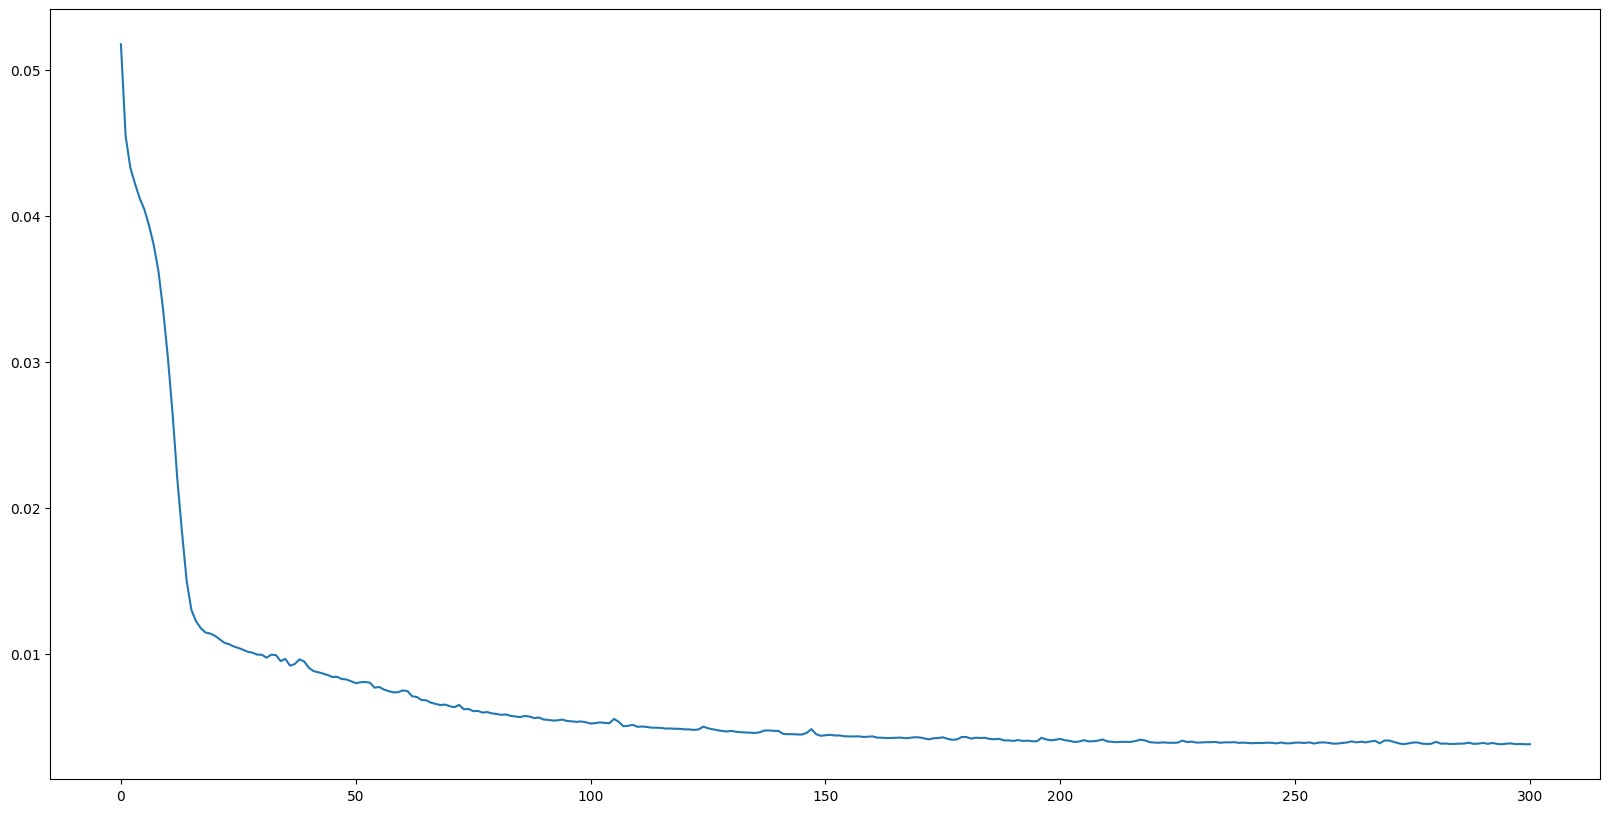

In [16]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

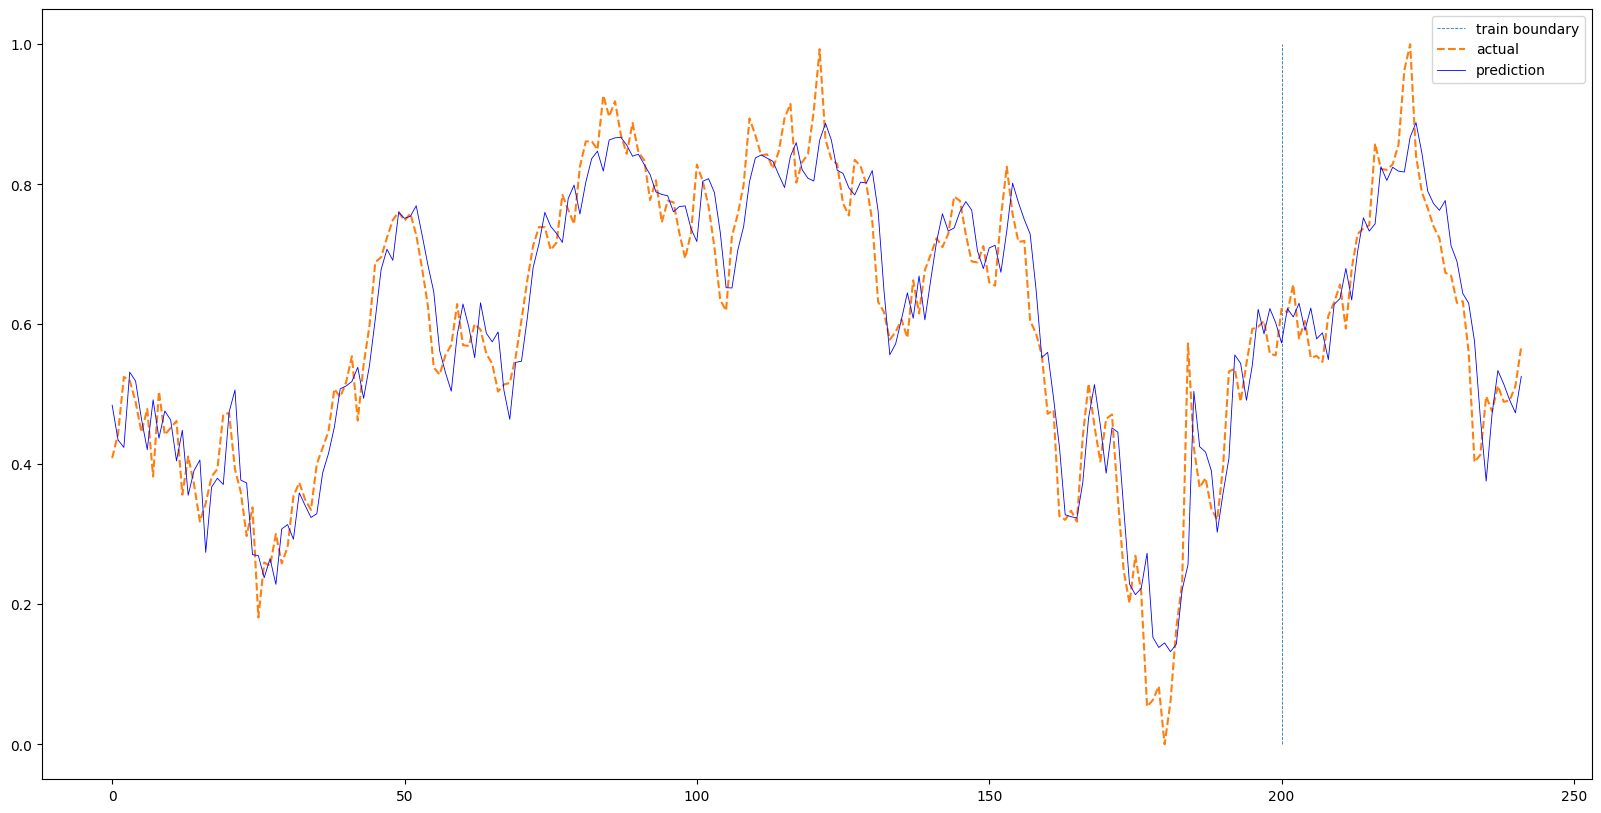

In [17]:
# 주가 그리기
# ConcatDataset은 여러 개의 데이터셋을 함께 사용할 수 있도록 도와줌

concatdata = torch.utils.data.ConcatDataset([train, test]) # 입력값은 데이터셋의 리스트를 받음
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100)
with torch.no_grad():
  pred = [] # 예측값 저장
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist() # CPU 텐서로 변환 후 리스트로 만들어 순차적으로 리스트 이어 붙임

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--',linewidth=0.6) # 학습 일수와 평가 일수를 구분짓는 선을 긋는다
# 실제값과 예측값 그리기
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b',linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

파란색 수직선을 기준으로 왼쪽을 훈련 데이터로 사용하고 오른쪽을 평가 데이터로 사용하였다

## 7.2 LSTM과 GRU
- RNN은 시퀀스의 길이가 길거나 관련 정보들 간의 거리가 멀면 학습 능력이 크게 하락할 수 있다. 해당 단점을 보완하고자 LSTM 개발되었고 이를 간소화한 GRU가 개발됨

### 7.2.2 LSTM(Long Short-Term Memory)
- 셀 상태 s와 모든 값이 0과 1 사이인 입력 게이트 i, 망각 게이트 f, 출력 게이트 o를 추가하여 이전 정보와 현재 정보를 비중을 조율하여 예측에 반영되고 그 값이 다음 타임 스텝으로 전달됨
- 모델 파라미터인 W와 U들이 자동 관리됨

In [18]:
# 모델 구축하기; 다른 부분은 다 동일

class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super(LSTM,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # 은닉 상태와 셀 상태를 계산해 다음 타임 스텝으로 넘겨줌
    # nn.LSTM로 한 줄 정의
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    # 은닉 상태와 셀 상태의 초깃값 0
    h0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.lstm(x,h0,c0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

### 7.2.3 GRU(Gated Recurrent Units)
- LSTM은 기본 RNN에서 추가로 셀 상태와 3개의 게이트를 사용하기에 속도가 느림. 이를 해결하기 위해 셀 상태를 없애고 2개의 게이트만 사용하여 LSTM 간소화한 것.

In [19]:
# 모델 구축하기; 다른 부분은 다 동일

class GRU(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super(GRU,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.gru(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

## 7.3 Bi-LSTM
- 지금까지는 이전 상태의 정보를 현재 상태로 넘겨주어 연산을 하는, 이른바 데이터 처리의 방향이 한 쪽으로 흐르는 정방향 연산임을 알 수 있음
- 다음 상태를 현재 연산에 활용하기 위해 양방향 LSTM (Bidirectional LSTM) => 정방향, 역방향에 대한 연산 합치자 Concatenate

### 7.3.1 Bi-LSTM 구현하기

In [20]:
# 라이브러리 불러오기

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [29]:
# MNIST 불러오기
# 배치 사이즈, 채널 수(1), 이미지 너비(28), 이미지 높이(28)
# or 이미지 픽셀의 각 열을 하나의 벡터로 보고 행을 타임 스텝으로 본다면 (배치사이즈, 시계열 길이, 벡터의 크기)를 가진 시계열 데이터로 생각도 가능

tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=False, transform=tensor_mode, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=tensor_mode, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [30]:
# Bi-LSTM 모델 구축하기

class BiLSTM(nn.Module):
  # 입력값의 크기(이미지의 열 크기), 은닉층의 노드수, 은닉층의 개수,시계열의 크기(이미지의 행 크기), 클래스 수, gpu 활용 여부
  def __init__(self,input_size,hidden_size,num_layers,seq_length,num_classes,device):
    super(BiLSTM,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length
    # 양방향 LSTM 생성
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True, bidirectional=True)
    # 모든 타임 스탭에 대한 LSTM 결과를 분류에 사용
    # 입력값 크기 = 시계열 길이 * 은닉층 크기 * 2 => comcatenate
    self.fc = nn.Linear(seq_length*hidden_size*2,num_classes)

  def forward(self,x):
    # 은닉 상태와 셀 상태의 초깃값 정의. 양방향이므로 은닉층 개수 * 2
    h0 = torch.zeros(self.num_layers*2,x.size(0),self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers*2,x.size(0),self.hidden_size).to(self.device)
    out,_ = self.lstm(x,(h0,c0))
    # 배치사이즈, 시계열 길이 * 은닉층 노드 수 * 2
    out = out.reshape(-1,self.seq_length*self.hidden_size*2)
    out = self.fc(out) # 10(클래스 수)
    return out

In [31]:
# 하이퍼 파라미터 정의

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = trainset.data.size(1) # 시계열 길이
input_size = trainset.data.size(2) # 입력 벡터 크기
num_layers = 2
hidden_size = 12
num_classes = 10

In [32]:
# 모델, 손실 함수, 최적화 기법 정의하기

model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [33]:
# 모델 학습하기

for epoch in range(51):
  correct = 0
  total = 0
  for data in trainloader:
    optimizer.zero_grad() # gradient 초기화
    # squeeze(1)를 통해 데이터 크기를 (배치사이즈,1,28,28) -> (배치사이즈,28,28) 변환
    inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # 학습 도중 정확도를 구할 때에는 변수 업데이트가 필요없으므로 detach()으로 outputs의 requires_grad 비활성화
    _, predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('[%d] train acc: %.2f' %(epoch, 100*correct/total))

[0] train acc: 74.40
[1] train acc: 93.50
[2] train acc: 95.67
[3] train acc: 96.66
[4] train acc: 97.33
[5] train acc: 97.86
[6] train acc: 98.04
[7] train acc: 98.43
[8] train acc: 98.90
[9] train acc: 99.22
[10] train acc: 99.29
[11] train acc: 99.23
[12] train acc: 99.60
[13] train acc: 99.68
[14] train acc: 99.79
[15] train acc: 99.88
[16] train acc: 99.80
[17] train acc: 99.95
[18] train acc: 100.00
[19] train acc: 99.99
[20] train acc: 99.97
[21] train acc: 99.93
[22] train acc: 99.95
[23] train acc: 99.77
[24] train acc: 98.32
[25] train acc: 99.31
[26] train acc: 99.69
[27] train acc: 99.85
[28] train acc: 99.97
[29] train acc: 99.99
[30] train acc: 100.00
[31] train acc: 100.00
[32] train acc: 100.00
[33] train acc: 100.00
[34] train acc: 100.00
[35] train acc: 100.00
[36] train acc: 100.00
[37] train acc: 100.00
[38] train acc: 100.00
[39] train acc: 100.00
[40] train acc: 100.00
[41] train acc: 100.00
[42] train acc: 100.00
[43] train acc: 100.00
[44] train acc: 100.00
[45]

In [34]:
# 모델 평가하기

def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  model.train()
  return acc

In [35]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print("Train Acc: %.1f, Test Acc: %.1f" %(train_acc, test_acc))

Train Acc: 100.0, Test Acc: 100.0
